In [9]:
# Download the dataset from Github
!wget https://github.com/das-lab/mpsd/archive/refs/heads/main.zip

# Unzip the downloaded zip file
!unzip main.zip

Streaming output truncated to the last 5000 lines.
  inflating: mpsd-main/mixed_malicious/515_2542.ps1  
  inflating: mpsd-main/mixed_malicious/516_116.ps1  
  inflating: mpsd-main/mixed_malicious/517_3515.ps1  
  inflating: mpsd-main/mixed_malicious/518_3800.ps1  
  inflating: mpsd-main/mixed_malicious/519_2612.ps1  
  inflating: mpsd-main/mixed_malicious/51_857.ps1  
  inflating: mpsd-main/mixed_malicious/520_65.ps1  
  inflating: mpsd-main/mixed_malicious/521_4383.ps1  
  inflating: mpsd-main/mixed_malicious/522_4318.ps1  
  inflating: mpsd-main/mixed_malicious/523_4434.ps1  
  inflating: mpsd-main/mixed_malicious/524_3278.ps1  
  inflating: mpsd-main/mixed_malicious/525_3199.ps1  
  inflating: mpsd-main/mixed_malicious/526_1155.ps1  
  inflating: mpsd-main/mixed_malicious/527_1899.ps1  
  inflating: mpsd-main/mixed_malicious/528_71.ps1  
  inflating: mpsd-main/mixed_malicious/529_3550.ps1  
  inflating: mpsd-main/mixed_malicious/52_3049.ps1  
  inflating: mpsd-main/mixed_malicious/

In [10]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [11]:
# Download NLTK data files (only need to run once)
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
import os
import glob
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

# Define paths to the datasets
malicious_pure_path = '/content/mpsd-main/malicious_pure'
mixed_malicious_path = '/content/mpsd-main/mixed_malicious'
benign_path = '/content/mpsd-main/powershell_benign_dataset'

def load_scripts_from_folder(folder_path):
    scripts = []
    file_paths = glob.glob(os.path.join(folder_path, '*.ps1'))
    for file_path in file_paths:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            scripts.append(file.read())
    return scripts

# Load scripts
malicious_pure_scripts = load_scripts_from_folder(malicious_pure_path)
mixed_malicious_scripts = load_scripts_from_folder(mixed_malicious_path)
benign_scripts = load_scripts_from_folder(benign_path)

# Label the scripts
malicious_labels = [1] * (len(malicious_pure_scripts) + len(mixed_malicious_scripts))
benign_labels = [0] * len(benign_scripts)

# Combine scripts and labels
all_scripts = malicious_pure_scripts + mixed_malicious_scripts + benign_scripts
all_labels = malicious_labels + benign_labels

# Create a DataFrame
data = pd.DataFrame({'script': all_scripts, 'label': all_labels})

# Initialize stopwords and punctuation
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

def preprocess_script(script):
    # Tokenize the script
    tokens = word_tokenize(script)
    # Convert to lowercase
    tokens = [token.lower() for token in tokens]
    # Remove punctuation
    tokens = [token for token in tokens if token not in punctuation]
    # Remove stopwords
    tokens = [token for token in tokens if token not in stop_words]
    # Join tokens back to string
    processed_script = ' '.join(tokens)
    return processed_script

# Apply preprocessing to all scripts
data['processed_script'] = data['script'].apply(preprocess_script)

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features as needed

# Fit and transform the data
X = vectorizer.fit_transform(data['processed_script'])

# Labels
y = data['label']

# Split data (e.g., 80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(
    n_estimators=100,  # Number of trees
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Train the model
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print evaluation results
print("Model Evaluation:")
print("-----------------")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Benign', 'Malicious']))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

import pickle

# Save the Random Forest Classifier
with open('rf_classifier.pkl', 'wb') as model_file:
    pickle.dump(rf_classifier, model_file)

# Save the TF-IDF Vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)

Model Evaluation:
-----------------
Accuracy : 0.9831
Precision: 0.9928
Recall   : 0.9816
F1 Score : 0.9871

Classification Report:
              precision    recall  f1-score   support

      Benign       0.96      0.99      0.98       863
   Malicious       0.99      0.98      0.99      1681

    accuracy                           0.98      2544
   macro avg       0.98      0.98      0.98      2544
weighted avg       0.98      0.98      0.98      2544

Confusion Matrix:
[[ 851   12]
 [  31 1650]]


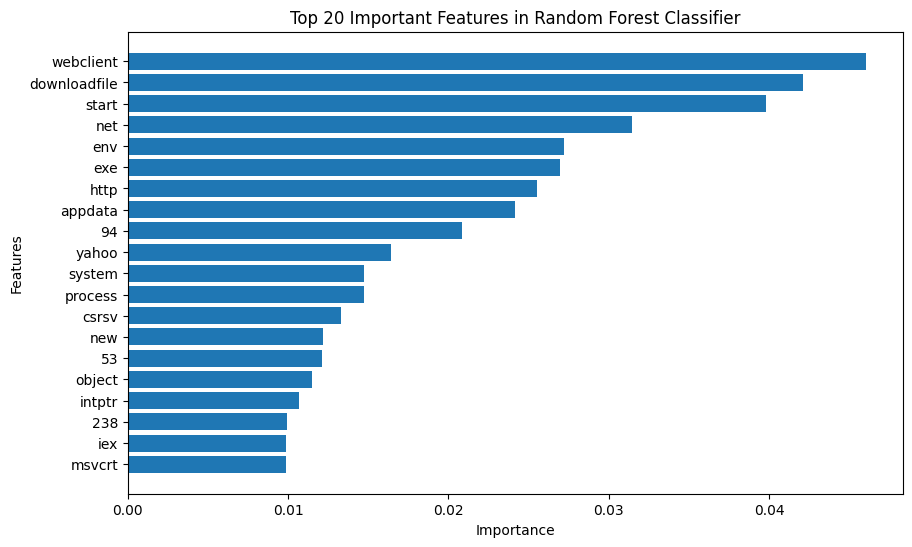

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importance from the Random Forest model
feature_importance = rf_classifier.feature_importances_

# Get feature names from the TF-IDF vectorizer
feature_names = vectorizer.get_feature_names_out()

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Visualize the top 20 features
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:20][::-1], importance_df['Importance'][:20][::-1])
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Top 20 Important Features in Random Forest Classifier")
plt.show()

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Initialize models
log_reg = LogisticRegression(max_iter=1000, random_state=42)
svm = SVC(kernel='linear', probability=True, random_state=42)

# Train Logistic Regression
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)

# Train SVM
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

# Evaluate Logistic Regression
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
precision_log_reg = precision_score(y_test, y_pred_log_reg)
recall_log_reg = recall_score(y_test, y_pred_log_reg)
f1_log_reg = f1_score(y_test, y_pred_log_reg)

print("Logistic Regression Evaluation:")
print(f"Accuracy : {accuracy_log_reg:.4f}")
print(f"Precision: {precision_log_reg:.4f}")
print(f"Recall   : {recall_log_reg:.4f}")
print(f"F1 Score : {f1_log_reg:.4f}")

# Evaluate SVM
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)

print("\nSVM Evaluation:")
print(f"Accuracy : {accuracy_svm:.4f}")
print(f"Precision: {precision_svm:.4f}")
print(f"Recall   : {recall_svm:.4f}")
print(f"F1 Score : {f1_svm:.4f}")

Logistic Regression Evaluation:
Accuracy : 0.9155
Precision: 0.9835
Recall   : 0.8870
F1 Score : 0.9327

SVM Evaluation:
Accuracy : 0.9233
Precision: 0.9831
Recall   : 0.8995
F1 Score : 0.9394


In [15]:
results = pd.DataFrame({
    'Model': ['Random Forest', 'Logistic Regression', 'SVM'],
    'Accuracy': [accuracy, accuracy_log_reg, accuracy_svm],
    'Precision': [precision, precision_log_reg, precision_svm],
    'Recall': [recall, recall_log_reg, recall_svm],
    'F1 Score': [f1, f1_log_reg, f1_svm]
})

print("\nComparison of Models:")
print(results)


Comparison of Models:
                 Model  Accuracy  Precision    Recall  F1 Score
0        Random Forest  0.983097   0.992780  0.981559  0.987137
1  Logistic Regression  0.915487   0.983509  0.886972  0.932749
2                  SVM  0.923349   0.983095  0.899465  0.939422
